inputs: best_model/

contents: evaluating the model

In [2]:
import mlflow
pipeline = mlflow.sklearn.load_model("best_model")

In [3]:
pipeline

Pipeline(steps=[('selector',
                 DataFrameSelector(attribute_names=Index(['age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object'))),
                ('preprocessor', DataPreprocessor()),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              col...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [4]:
import pandas as pd
test_df = pd.read_csv("data/test_df.csv")

In [5]:
predictions = pipeline.predict(test_df)

In [6]:
import yaml
with open('data/heart_disease_metadata.yaml', 'r') as f:
    metadata = yaml.safe_load(f)

In [7]:
import shap
# analyze the predictions using shap
model = pipeline.named_steps['regressor']

# Extract the preprocessing steps from the pipeline
# Assuming 'classifier' is the last step in the pipeline
preprocessing_pipeline = pipeline[:-1]  # Exclude the last step (classifier)

# Transform the input data using the preprocessing steps
preprocessed_input = preprocessing_pipeline.transform(test_df)


feature_names = test_df.columns
feature_titles = [metadata[col]['title'] if col in metadata and 'title' in metadata[col] else col for col in feature_names]
explainer = shap.TreeExplainer(model)
shap_values = explainer(preprocessed_input)


/Users/uberj/miniconda/envs/hd_cursor/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


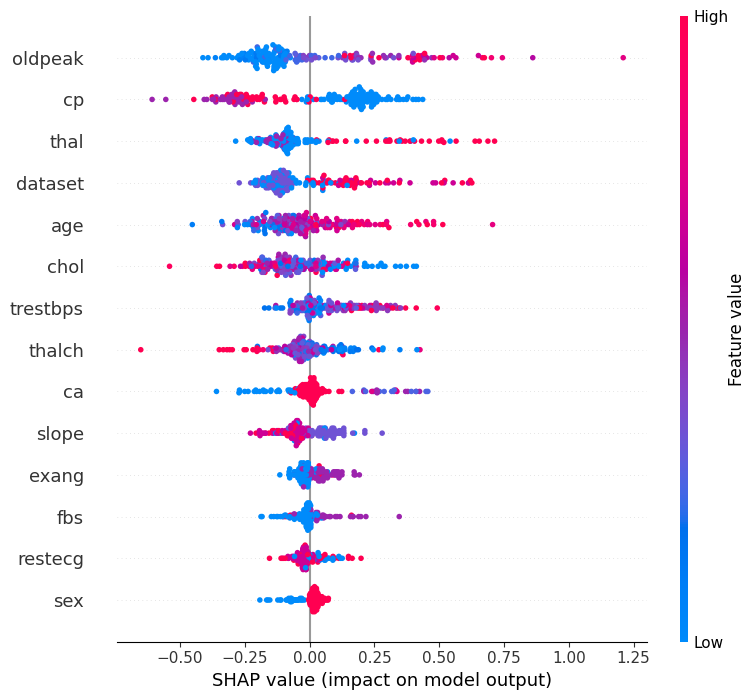

In [8]:
shap.summary_plot(shap_values, preprocessed_input)

In [9]:
preprocessed_input

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,10,1,1,0,8,217,0,2,49,1,20,1,4,1
1,33,1,2,0,20,0,0,2,4,1,10,0,4,3
2,34,1,3,1,16,106,0,0,112,1,10,2,4,1
3,29,1,0,0,45,141,1,0,23,0,20,1,3,3
4,41,1,3,2,61,123,0,0,119,2,53,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,23,1,0,3,20,65,0,0,24,1,24,3,1,2
180,27,1,1,1,43,144,1,2,42,1,30,1,4,1
181,33,1,2,0,37,0,0,2,16,1,30,1,4,3
182,29,1,2,0,31,0,0,2,19,1,30,1,4,0


In [11]:
shap.force_plot(explainer.expected_value, shap_values[:1000, :].values, preprocessed_input.iloc[:1000, :])